# Linkedin Social Network Link Analysis
A project on analyzing social networks using recommender systems techniques.

## Imports

In [29]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

In [3]:
df_raw = pd.read_csv("../data/Connections.csv")
df_raw

,First Name,Last Name,URL,Email Address,Company,Position,Connected On
0,Kamesh,Anuradha,https://www.linkedin.com/in/kamesh-anuradha,NaN,ISA,AI Engineer,27 Jan 2026
1,Hirushi Chameesha,de Silva,https://www.linkedin.com/in/hirushi-chameesha-...,NaN,Emojot,QA Lead,26 Jan 2026
2,Anuruddha,Liyanarachchi,https://www.linkedin.com/in/anuruddhal,NaN,WSO2,Technical Lead,26 Jan 2026
3,Ruvini,Rajapaksha,https://www.linkedin.com/in/ruvini-rajapaksha-...,NaN,Virtusa,Senior Consultant,25 Jan 2026
4,Shakya,Dissanayake,https://www.linkedin.com/in/shakyadissanayake,NaN,"Augustory, Corp. (Formerly Nerve8)",Machine Learning Engineer,24 Jan 2026
...,...,...,...,...,...,...,...
1675,Movindu,Thiumila Gunarathna,https://www.linkedin.com/in/movindugunarathna,NaN,Toyota Lanka (Private) Limited,Project Assistant,07 Oct 2021
1676,Sandhu,Divyan MBCS,https://www.linkedin.com/in/sandhu-divyan-mbcs...,NaN,Umbrella Transfers - London Airport Transfers ...,SEO & SEM Specialist,07 Oct 2021
1677,Santhusha Janana,Mudannayaka,https://www.linkedin.com/in/santhusha-mudannayaka,NaN,Berkeley SkyDeck,Software Engineer Intern,05 Oct 2021
1678,Odil,Janandith,https://www.linkedin.com/in/odil-janandith-940...,NaN,RoboticGen Academy,Chief Technology Officer,04 Oct 2021


In [4]:
df_raw.info()

<class 'pandas.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   First Name     1652 non-null   str  
 1   Last Name      1652 non-null   str  
 2   URL            1652 non-null   str  
 3   Email Address  30 non-null     str  
 4   Company        1427 non-null   str  
 5   Position       1427 non-null   str  
 6   Connected On   1680 non-null   str  
dtypes: str(7)
memory usage: 92.0 KB


In [5]:
df_raw.describe()

,First Name,Last Name,URL,Email Address,Company,Position,Connected On
count,1652,1652,1652,30,1427,1427,1680
unique,1264,1154,1652,30,803,783,694
top,Kavindu,Fernando,https://www.linkedin.com/in/kamesh-anuradha,nirashanipuninn98@gmail.com,WSO2,Software Engineer Intern,18 Nov 2025
freq,17,38,1,1,132,146,19


## Data Preprocessing

### Drop NA

In [6]:
df_full = df_raw.copy()[['First Name', 'Last Name', 'Company', 'Position', 'Connected On']]
df_full = df_full.dropna().reset_index(drop=True)
print("DataFrame shape after dropping NA:", df_full.shape)
df_full.head()

DataFrame shape after dropping NA: (1427, 5)


,First Name,Last Name,Company,Position,Connected On
0,Kamesh,Anuradha,ISA,AI Engineer,27 Jan 2026
1,Hirushi Chameesha,de Silva,Emojot,QA Lead,26 Jan 2026
2,Anuruddha,Liyanarachchi,WSO2,Technical Lead,26 Jan 2026
3,Ruvini,Rajapaksha,Virtusa,Senior Consultant,25 Jan 2026
4,Shakya,Dissanayake,"Augustory, Corp. (Formerly Nerve8)",Machine Learning Engineer,24 Jan 2026


### Add full name

In [24]:
df_full['Full Name'] = df_full[["First Name", "Last Name"]].agg(' '.join, axis=1)

### Sample data

In [25]:
df = df_full.groupby('Company', group_keys=False).sample(frac=0.2, random_state=42).reset_index(drop=True)
print("Sampled DataFrame shape:", df.shape)
df.head()

Sampled DataFrame shape: (141, 6)


,First Name,Last Name,Company,Position,Connected On,Full Name
0,Nimesh,Karunaratne,4Axis,Associate Software Quality Assurance Engineer,01 Jun 2023,Nimesh Karunaratne
1,Chathulanka,Gamage,99x,Senior Software Engineer,17 Jan 2026,Chathulanka Gamage
2,Poornima,Kahatapitiya,99x,Technical Lead: Agentic AI,08 Jan 2026,Poornima Kahatapitiya
3,Pasindu,Aluthwalahewa,99x,Associate Software Engineer,09 Jun 2025,Pasindu Aluthwalahewa
4,Kumal,Hewagamage,A*STAR Institute of High Performance Computing...,Research Intern,08 Nov 2021,Kumal Hewagamage


In [26]:
df['Company'].value_counts()

Company
WSO2                         26
University of Moratuwa        5
IFS                           4
99x                           3
CodeGen International         3
                             ..
WIWIS.AI                      1
Zebra Technologies            1
hSenid Business Solutions     1
iVedha Inc.                   1
icieos                        1
Name: count, Length: 92, dtype: int64

In [27]:
df = df_full.copy()

## Make Graph

### Make connection between me and others

In [28]:
G = nx.Graph()

MY_NODE = "Ravindu Weerasinghe"
NODES = df_full["Full Name"].tolist()
NODES.append(MY_NODE)
EDGES = df_full["Full Name"].apply(lambda x: (x, MY_NODE)).tolist()

### Make connection between others

In [30]:
company_edges = df_full.groupby('Company')['Full Name'].apply(lambda x: list(combinations(x, 2)) if len(x) > 1 else []).explode().dropna().tolist()
EDGES.extend(company_edges)

### Make graph

In [33]:
assert NODES is not None, "NODES list should not be None"
assert EDGES is not None, "EDGES list should not be None"
assert len(NODES) == len(df_full) + 1, "NODES list length should be equal to number of connections plus one for MY_NODE"
assert len(EDGES) >= len(df_full), "EDGES list length should be equal to or greater than number of connections"

G.add_nodes_from(NODES)
G.add_edges_from(EDGES)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 1427
Number of edges: 11965


### Subgraph visualization

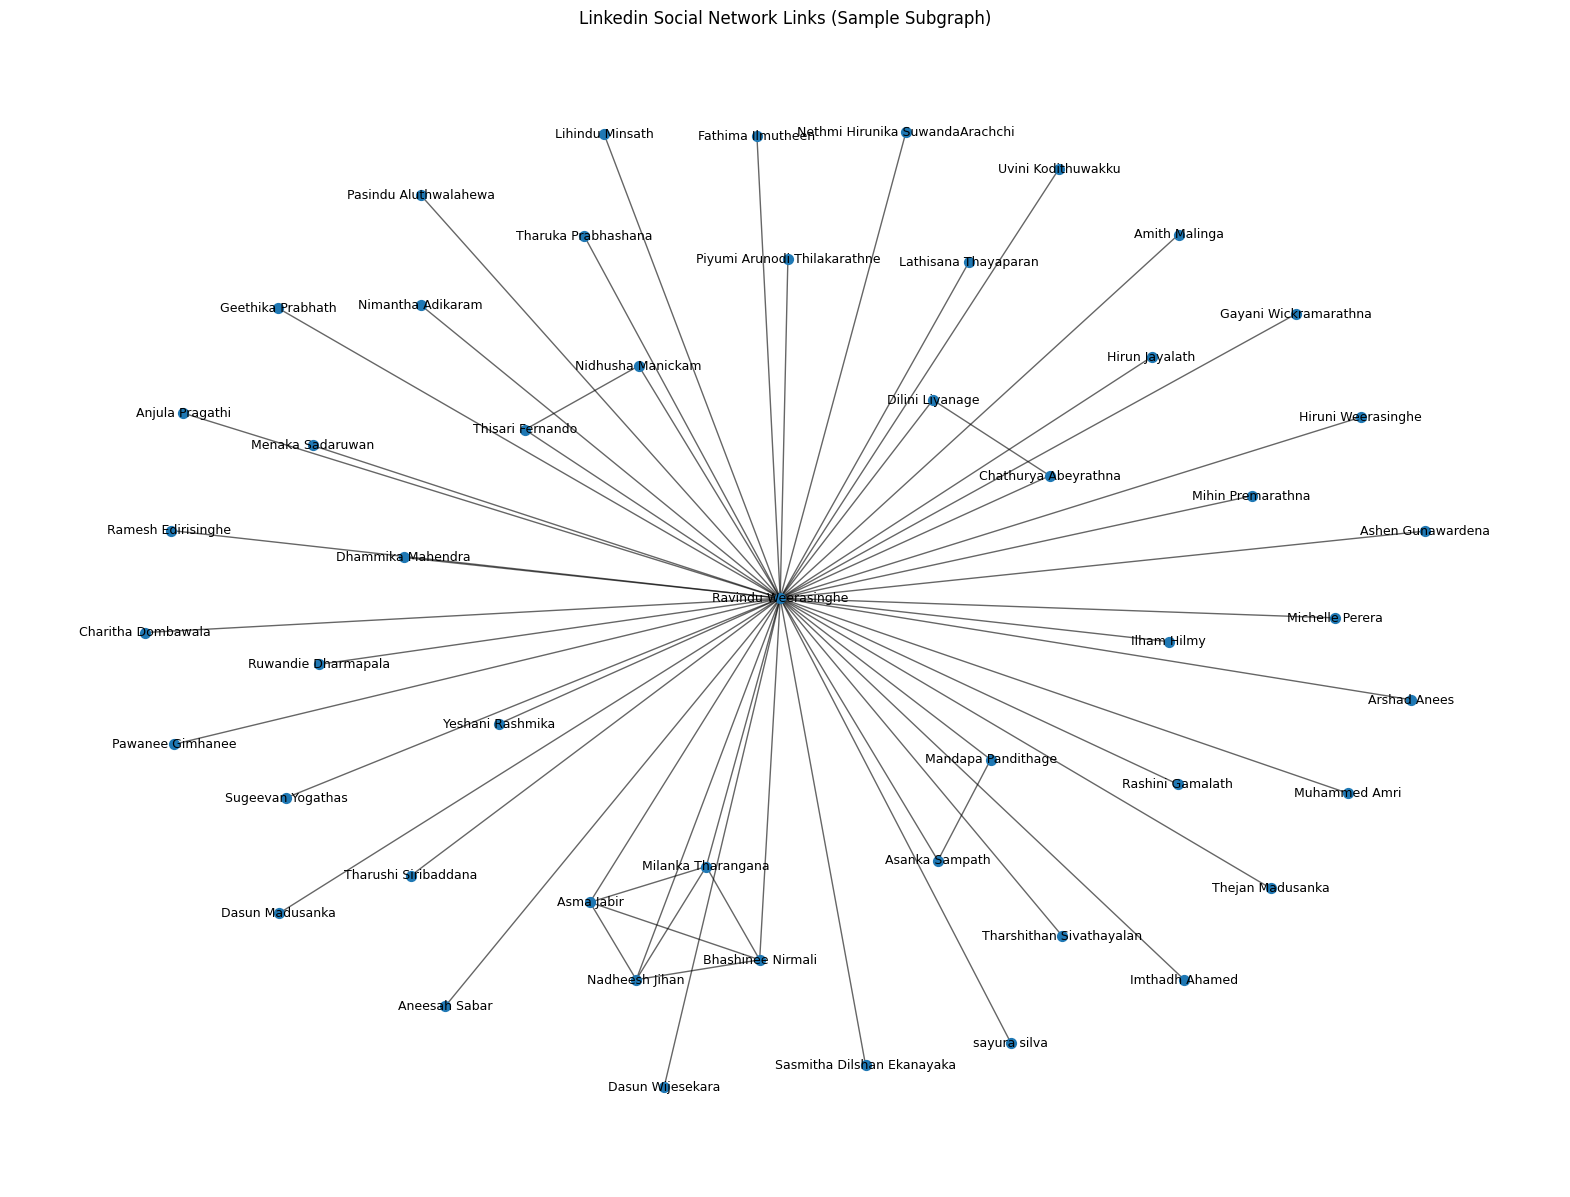

In [32]:
sample_size = 50
sampled_nodes = np.random.choice(NODES, size=min(sample_size, len(NODES)), replace=False)
if MY_NODE not in sampled_nodes:
    sampled_nodes[0] = MY_NODE  # Ensure MY_NODE is included

G_sample = G.subgraph(sampled_nodes)

plt.figure(figsize=(20, 15))
pos = nx.spring_layout(G_sample, seed=42)  # stable layout

nx.draw_networkx_nodes(G_sample, pos, node_size=50)
nx.draw_networkx_labels(G_sample, pos, font_size=9)
nx.draw_networkx_edges(G_sample, pos, arrows=False, width=1, alpha=0.6)

plt.title("Linkedin Social Network Links (Sample Subgraph)")
plt.axis("off")
plt.show()

## Helper Functions

In [ ]:
def to_ranked_df(metric_dicts, col_names, top_n=None, ascending=False):
    """Convert a dictionary {node: value} to a sorted DataFrame."""

    keys = list(metric_dicts.keys())
    for metric_dict in metric_dicts:
        
    df = pd.DataFrame(metric_dict.items(), columns=["node", col_name])
    df = df.sort_values(col_name, ascending=ascending).reset_index(drop=True)

    if top_n:
        df = df.head(top_n)
    return df

def show(title, metric_dicts, col_names, k=10, top=True):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    if top:
        display(to_ranked_df(metric_dicts, col_names=col_names).head(k))
    else:
        display(to_ranked_df(metric_dicts, col_names=col_names).tail(k))

def show_top(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=True)

def show_bottom(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=False)

In [37]:
def to_ranked_df(metric_dicts, col_names, top_n=None, ascending=False):
    """Convert one or more dictionaries {node: value} to a sorted DataFrame.
    
    Args:
        metric_dicts: dict or list of dicts with {node: value} structure
        col_names: str or list of str for column names
        top_n: int, limit rows to top_n
        ascending: bool, sort order
    """
    # Handle single dict vs multiple dicts
    if isinstance(metric_dicts, dict):
        metric_dicts = [metric_dicts]
    
    if isinstance(col_names, str):
        col_names = [col_names]
    
    # Ensure we have matching number of dicts and column names
    assert len(metric_dicts) == len(col_names), "Number of dicts must match number of column names"
    
    # Get all nodes from first dict
    nodes = list(metric_dicts[0].keys())
    
    # Create DataFrame
    data = {"node": nodes}
    for metric_dict, col_name in zip(metric_dicts, col_names):
        data[col_name] = [metric_dict.get(node, None) for node in nodes]
    
    df = pd.DataFrame(data)
    
    # Sort by first metric column
    df = df.sort_values(col_names[0], ascending=ascending).reset_index(drop=True)
    
    if top_n:
        df = df.head(top_n)
    
    return df

def show(title, metric_dicts, col_names, k=10, top=True):
    print("\n" + "="*len(title))
    print(title)
    print("="*len(title))
    if top:
        display(to_ranked_df(metric_dicts, col_names=col_names).head(k))
    else:
        display(to_ranked_df(metric_dicts, col_names=col_names).tail(k))

def show_top(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=True)

def show_bottom(title, metric_dicts, col_names, k=10):
    show(title, metric_dicts, col_names, k=k, top=False)

## Link Analysis

### Degree Centrality

In [49]:
degree = dict(G.degree())
degree_centrality = nx.degree_centrality(G)
show_top("Top by Degree Centrality", [degree, degree_centrality], ["degree", "degree_centrality"], k=542)


Top by Degree Centrality


,node,degree,degree_centrality
0,Ravindu Weerasinghe,1426,1.000000
1,Anuruddha Liyanarachchi,132,0.092567
2,Bhashinee Nirmali,132,0.092567
3,Chathuranga Jayanath,132,0.092567
4,Omindu Rathnaweera,132,0.092567
...,...,...,...
537,Chathuri Thambugala,4,0.002805
538,Ruvini Rajapaksha,4,0.002805
539,Kamesh Anuradha,4,0.002805
540,Kumal Hewagamage,3,0.002104


### Closeness Centrality

In [52]:
closeness = nx.closeness_centrality(G)
show_top("Top by Closeness Centrality", [closeness], ["closeness_centrality"], k=542)


Top by Closeness Centrality


,node,closeness_centrality
0,Ravindu Weerasinghe,1.000000
1,Anuruddha Liyanarachchi,0.524265
2,Bhashinee Nirmali,0.524265
3,Chathuranga Jayanath,0.524265
4,Omindu Rathnaweera,0.524265
...,...,...
537,Chathuri Thambugala,0.500702
538,Ruvini Rajapaksha,0.500702
539,Kamesh Anuradha,0.500702
540,Kumal Hewagamage,0.500527


### Betweenness Centrality

In [53]:
betweenness = nx.betweenness_centrality(G, normalized=True)
show_top("Top by Betweenness Centrality", [betweenness], ["betweenness_centrality"], k=542)


Top by Betweenness Centrality


,node,betweenness_centrality
0,Ravindu Weerasinghe,0.989627
1,Ruvini Rajapaksha,0.000000
2,Kamesh Anuradha,0.000000
3,Roshen Yapa,0.000000
4,Sandil Mallikarachchi,0.000000
...,...,...
537,Ashan Thennakoon,0.000000
538,Malisha Kapugamage,0.000000
539,Benuka Punchihewa,0.000000
540,Chamalka Obadage,0.000000


### Eigenvector Centrality

In [54]:
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)
show_top("Top by Eigenvector Centrality", [eigenvector], ["eigenvector_centrality"], k=542)


Top by Eigenvector Centrality


,node,eigenvector_centrality
0,Ravindu Weerasinghe,0.093696
1,Anuruddha Liyanarachchi,0.086626
2,Bhashinee Nirmali,0.086626
3,Chathuranga Jayanath,0.086626
4,Omindu Rathnaweera,0.086626
...,...,...
537,Chathuri Thambugala,0.000726
538,Ruvini Rajapaksha,0.000726
539,Kamesh Anuradha,0.000726
540,Kumal Hewagamage,0.000720


### Local Clustering Coefficient

In [75]:
clustering = nx.clustering(G)
show_top("Top by Local Clustering Coefficient", [clustering], ["clustering_coefficient"], k=804)


Top by Local Clustering Coefficient


,node,clustering_coefficient
0,Thevindu Dissanayake,1.000000
1,Kamesh Anuradha,1.000000
2,Jahzan Ahamed,1.000000
3,Kumal Hewagamage,1.000000
4,Yasindu Weraniyagoda,1.000000
...,...,...
799,Anuruddha Liyanarachchi,1.000000
800,Ravindu Weerasinghe,0.010373
801,Shakya Dissanayake,0.000000
802,Janaka Chathuranga Thilakarathna Brahmanage,0.000000
